In [1]:
import graph_tool as gt
import graph_tool.topology as top
import networkx as nx
import numpy as np

In [86]:
k = 6
pattern = nx.cycle_graph(k)
edge_list = list(pattern.edges)

graph = nx.Graph()
nx.add_cycle(graph, range(0, 4))
nx.add_star(graph, range(4-1, 7))
nx.add_cycle(graph, [7-1, 7, 11, 22, 33, 44])
nx.add_cycle(graph, [33, 55, 66, 77, 88, 44])
graph_edge_list = list(graph.edges)

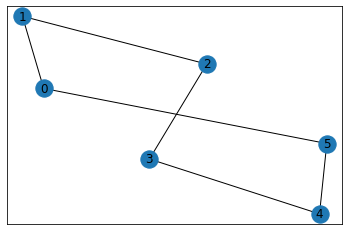

In [87]:
nx.draw_networkx(pattern, with_labels=True)

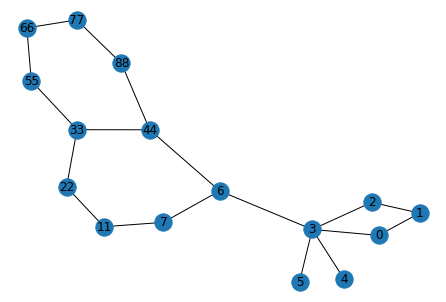

In [88]:
nx.draw(graph, with_labels=True)

In [115]:
get_rings(graph_edge_list)

[(33, 44, 88, 77, 66, 55), (0, 1, 2, 3), (6, 7, 11, 22, 33, 44)]

In [108]:
pattern_gt = gt.Graph(directed=False)
pattern_gt.add_edge_list(edge_list)
graph_gt = gt.Graph(directed=False)
graph_gt.add_edge_list(graph_edge_list)
gt.stats.remove_self_loops(graph_gt)
gt.stats.remove_parallel_edges(graph_gt)  

sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, generator=True)

In [113]:
def get_rings(edge_index, max_k=7):
    '''
    '''
#     edge_list = edge_index.numpy().T
    edge_list = edge_index
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    gt.stats.remove_self_loops(graph_gt)
    gt.stats.remove_parallel_edges(graph_gt)
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, generator=True)
        sub_iso_sets = map(lambda x: tuple(x.a), sub_iso)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings

In [107]:
for i, iso in enumerate(sub_iso):
    print(i, iso.a)

0 [ 6  7 11 22 33 44]
1 [ 6 44 33 22 11  7]
2 [ 7  6 44 33 22 11]
3 [ 7 11 22 33 44  6]
4 [11  7  6 44 33 22]
5 [11 22 33 44  6  7]
6 [22 11  7  6 44 33]
7 [22 33 44  6  7 11]
8 [33 22 11  7  6 44]
9 [33 44  6  7 11 22]
10 [33 44 88 77 66 55]
11 [33 55 66 77 88 44]
12 [44  6  7 11 22 33]
13 [44 33 22 11  7  6]
14 [44 33 55 66 77 88]
15 [44 88 77 66 55 33]
16 [55 33 44 88 77 66]
17 [55 66 77 88 44 33]
18 [66 55 33 44 88 77]
19 [66 77 88 44 33 55]
20 [77 66 55 33 44 88]
21 [77 88 44 33 55 66]
22 [88 44 33 55 66 77]
23 [88 77 66 55 33 44]


In [ ]:
def get_rings(edge_index, max_k=7):
    '''
    '''
#     edge_list = edge_index.numpy().T
    edge_list = edge_index
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    gt.stats.remove_self_loops(graph_gt)
    gt.stats.remove_parallel_edges(graph_gt)
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, generator=True)
        sub_iso_sets = map(lambda x: tuple(x.a), sub_iso)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings


def build_tables_with_rings(edge_index, simplex_tree, size, max_k):
    
    simplex_tables, id_maps = build_tables(simplex_tree, size)
    rings = get_rings(edge_index, max_k=max_k)
    
    # Extend the tables with rings
    id_maps += [{}]
    simplex_tables += []
    assert len(simplex_tables) == 3
 
    for cell in rings:
        next_id = len(simplex_tables[2])
        id_maps[2][cell] = next_id
        simplex_tables[2].append(cell)

    return simplex_tables, id_maps


def get_ring_faces(ring):
    faces = list()
    for n in len(ring):
        a = n
        if n == len(ring):
            b = 0
        else:
            b = n + 1
        faces.append(tuple(sorted([a,b])))
    return faces


def extract_faces_and_cofaces_from_simplex_tree_with_rings(simplex_tree, id_maps):
    """Build two maps cell -> its cofaces and cell -> its faces"""
    
    assert simplex_tree.dimension() == 1     
    faces_tables, faces, cofaces = extract_faces_and_cofaces_from_simplex_tree(simplex_tree, id_maps, simplex_tree.dimension())
    
    # extend tables
    complex_dim = 2
    faces += [{}]
    cofaces += [{}]
    faces_tables += []
    
    for cell in id_maps[2]:
        cell_faces = get_ring_faces(cell)
        faces[2][cell] = list()
        for face in cell_faces:
            assert face in id_maps[1]
            faces[2][cell].append(face)
            if face not in cofaces[1]:
                cofaces[1][face] = list()
            cofaces[1][face].append(cell)
            faces_table[2].append(id_maps[1][face])
    
    return faces_tables, faces, cofaces


def compute_ring_2complex_with_graphtool_and_gudhi(x: Tensor, edge_index: Adj, size: int,
                                                   y: Tensor = None, max_k: int = 7,
                                                   include_down_adj=True,
                                                   init_method: str = 'sum') -> Complex:
    """Generates a ring 2-complex of a pyG graph via graph-tool.

    Args:
        x: The feature matrix for the nodes of the graph
        edge_index: The edge_index of the graph (a tensor of shape [2, num_edges])
        size: The number of nodes in the graph
        y: Labels for the graph nodes or a label for the whole graph.
        max_k: maximum length of rings to look for.
        include_down_adj: Whether to add down adj in the complex or not
        init_method: How to initialise features at higher levels.
    """
    assert x is not None
    assert isinstance(edge_index, Tensor)  # Support only tensor edge_index for now

    # Creates the gudhi-based simplicial complex
    simplex_tree = pyg_to_simplex_tree(edge_index, size)
    simplex_tree.expansion(1)  # Computes the clique complex up to the edge dim.
    assert simplex_tree.dimension() == 1 # See what is the dimension of the complex now.

    # Builds tables of the simplicial complexes at each level and their IDs
    simplex_tables, id_maps = build_tables_with_rings(edge_index, simplex_tree, size, max_k)

    # Extracts the faces and cofaces of each simplex in the complex
    faces_tables, faces, co_faces = (
        extract_faces_and_cofaces_from_simplex_tree_with_rings(simplex_tree, id_maps))

    # Computes the adjacencies between all the simplexes in the complex
    shared_faces, shared_cofaces, lower_idx, upper_idx = build_adj_gudhi(faces, co_faces, id_maps,
                                                                         2, include_down_adj)

    # Construct features for the higher dimensions
    # TODO: Make this handle edge features as well and add alternative options to compute this.
    xs = construct_features(x, simplex_tables, init_method)

    # Initialise the node / complex labels
    v_y, complex_y = extract_labels(y, size)

    chains = []
    for i in range(complex_dim+1):
        y = v_y if i == 0 else None
        chain = generate_chain_gudhi(i, xs[i], upper_idx, lower_idx, shared_faces, shared_cofaces,
                                     simplex_tables, faces_tables, complex_dim=2, y=y)
        chains.append(chain)

    return Complex(*chains, y=complex_y, dimension=2)

In [126]:
import torch
x = torch.randn(3, 4)
print(x)
print()
indices = torch.tensor([0, -1])
print(torch.index_select(x, 0, indices))

tensor([[-0.2365, -1.2710,  2.0893, -0.0691],
        [-1.0647,  1.0641,  1.8500, -2.4477],
        [ 0.0680,  0.1687,  0.4038,  2.4257]])



IndexError: index out of range in self

ValueError: cannot convert float NaN to integer